In [13]:
from __future__ import division
from lxml import etree
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import requests
import zipfile
import os
import runProcs
%matplotlib inline

In [14]:
# 0. Define a functions for managing parsed z1 data

# 0.1 Create a searchable legend in csv format
def createLegend(root):

    legend_df = pd.DataFrame(columns=['Series Name','Description','Frequency','Start','End'])
    x = 0

    for levelA in root:
        for levelB in levelA[4:-1]:
            entry = []
            ident = levelB.get('SERIES_NAME')
            freq = ident[-1]
            entry.append(ident)
            for levelC in levelB:
                for n,levelD in enumerate(levelC):
                    if n == 0:
                        entry.append(levelD[1].text)
                        entry.append(freq)      
            for levelC in [levelB[1],levelB[-1]]:
                d= levelC.get('TIME_PERIOD')
                d= datetime.datetime.strptime(d, '%Y-%m-%d').strftime('%m-%d-%Y')
                entry.append(d)

            legend_df.loc[x] = entry
            x+=1
            
    legend_df.to_csv('z1Legend.csv')

    return legend_df

# 0.2 Create a Pandas dataframe for the z1 series with code: name 
def getSeries(name):
    
    dates = []
    value= np.array([])
    for levelA in root:
        for levelB in levelA:
            ident = levelB.get('SERIES_NAME')
            if ident in [name]:
                for levelC in levelB:
                    for n,levelD in enumerate(levelC):
                        if n == 0:
                            description = levelD[1].text

                for levelC in levelB[1:]:
                    v = levelC.get('OBS_VALUE')
                    d= levelC.get('TIME_PERIOD')
                    dates = np.append(dates,d)
                    value = np.append(value,float(v))

    for n,d in enumerate(dates):
        dates[n]= datetime.datetime.strptime(d,'%Y-%m-%d').strftime('%m-%d-%Y')
        
    df = pd.DataFrame(value,index=dates,columns = [description])
    return df

# 0.3 Create a Pandas dataframe for the z1 series with codes in dataList
def getDataSet(dataList):
    df = pd.DataFrame([])
    for name in dataList:
        newSeries=getSeries(name)
        df = pd.concat([df,newSeries],axis=1, join_axes=[newSeries.index])
    return df

In [15]:
# 1. Download .zip file and extract .xml (and other contents if necessary)


# 1.1 download
url = "http://www.federalreserve.gov/datadownload/Output.aspx?rel=Z1&filetype=zip"

file_name = "FRB_Z1.zip"
u = requests.get(url)

with open(file_name, 'wb') as f:
    for chunk in u.iter_content(chunk_size=1024): 
        if chunk: # filter out keep-alive new chunks
            f.write(chunk)
            f.flush()
f.close()

# 1.2 extract

fh = open('FRB_Z1.zip', 'rb')
z = zipfile.ZipFile(fh)
for name in ['Z1_data.xml']:
    outpath = ""
    z.extract(name, outpath)
fh.close()

# with zipfile.ZipFile('FRB_Z1.zip', "r") as z:
#     z.extractall()

# 1.3 Remove the zip file
os.remove('FRB_Z1.zip')

In [16]:
# 2. Import the xml data and create a legend

# 2.2 parse
tree = etree.parse("Z1_data.xml")
root = tree.getroot()

# 2.2 create a legend in csv format
# legend= createLegend(root)

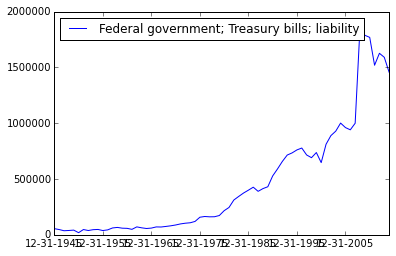

In [17]:
# 3. Sample plot: US T-bill volume
tBills = getSeries('FL313161113.A')
tBills.plot(x_compat=True)

In [18]:
# 4. export the notebook
runProcs.exportNb('z1data')